### Covid-19 country trends
* author   : santosh
* date     : 05.04.2020
* purpose  : country level summaries-'Infections', 'Recovery', 'Deaths', 'Case Fatality Rates'
* instance : local

<font color='tan'> setup

In [1]:
#import dependencies
#data wrangling
import numpy as np
import pandas as pd
import dfply as dfp
import datetime as dt
#plot
import matplotlib.pyplot as plt
plt.style.use('dark_background')
import seaborn as sb
#helper funcs
from helper_funcs import isUnique

In [2]:
#display options
pd.options.display.html.table_schema = True
pd.set_option('display.max_rows', 999)
%matplotlib inline

<font color='tan'> ingest scrubbed analysis data

In [3]:
#read csv file
country_df = pd.read_csv('../data/covid19_country_analysis_data.csv', sep=',', parse_dates=['Date'])

In [4]:
#ensure daily counts are not below zero
country_df['Confirmed_New'] = country_df['Confirmed_New'].apply(lambda x:max(0,x))
country_df['Deaths_New']    = country_df['Deaths_New'].apply(lambda x:max(0,x))
country_df['Recovered_New'] = country_df['Recovered_New'].apply(lambda x:max(0,x))

In [5]:
#check info on analysis data
country_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19261 entries, 0 to 19260
Data columns (total 11 columns):
Confirmed         19261 non-null int64
Confirmed_New     19261 non-null float64
Country_Region    19261 non-null object
Date              19261 non-null datetime64[ns]
Deaths            19261 non-null int64
Deaths_New        19261 non-null float64
Recovered         19261 non-null int64
Recovered_New     19261 non-null float64
year              19261 non-null int64
month             19261 non-null int64
year_month        19261 non-null object
dtypes: datetime64[ns](1), float64(3), int64(5), object(2)
memory usage: 1.6+ MB


In [6]:
#check uniqueness
print('\nanalysis data unique in Country and Date: ',isUnique(country_df, ['Country_Region','Date']))


analysis data unique in Country and Date:  True


<font color='tan'> user inputs for cumulative & daily trends

In [41]:
topnum = 5 #number of countries to display
metric_cum = 'Confirmed' #choose 'Confirmed','Recovered' or 'Deaths'
metric_new = metric_cum+'_New'

In [42]:
#create list of top countries based on cumulative metric selected (with and without US)
#including US
top_ius = country_df.groupby(['Country_Region'],as_index=False)\
.agg({metric_cum:'max'})\
.sort_values(by=[metric_cum], ascending=False)\
.head(topnum)['Country_Region']\
.tolist()

#excluding US
top_xus = country_df.loc[country_df['Country_Region'] != 'US']\
.groupby(['Country_Region'],as_index=False)\
.agg({metric_cum:'max'})\
.sort_values(by=[metric_cum], ascending=False)\
.head(topnum)['Country_Region']\
.tolist()

<font color='tan'> plot trends

In [43]:
#func to plot cumulative and daily trends
def getCovidTrend(metric, sel):
    """
    this function takes in the metric and country list as input and returns a plot of
    cumulative and daily trends by top countries (including US)
    """
    #filter and transpose data
    p_df = country_df.loc[country_df['Country_Region'].isin(sel)]\
    .pivot_table(values=metric, index=['Date'], columns='Country_Region')\
    .reset_index().fillna(0)
    p_df.set_index('Date', inplace=True)
    #plot
    p_df.plot.line(figsize=(14,8))
    plt.title('Covid-19 trends: '+metric, size=20)
    plt.xlabel('Date',size=14)
    plt.xticks(size=14, color='white')
    plt.yticks(size=14, color='white')
    plt.show()

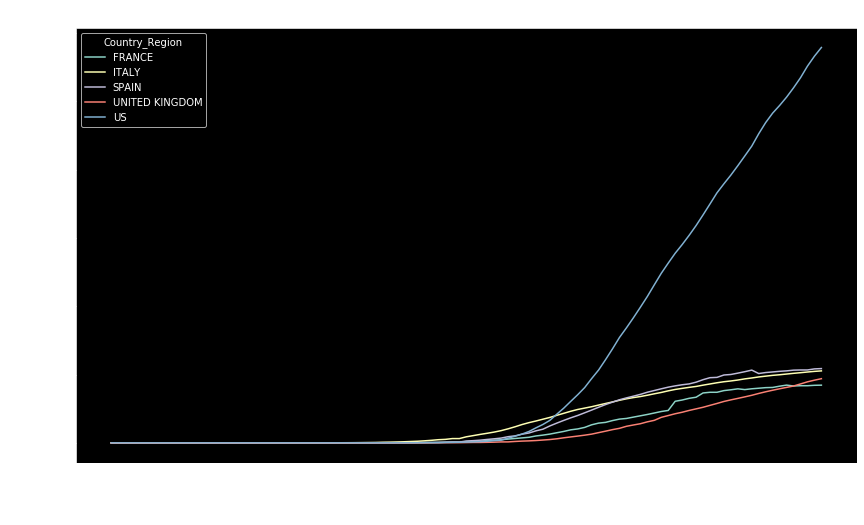

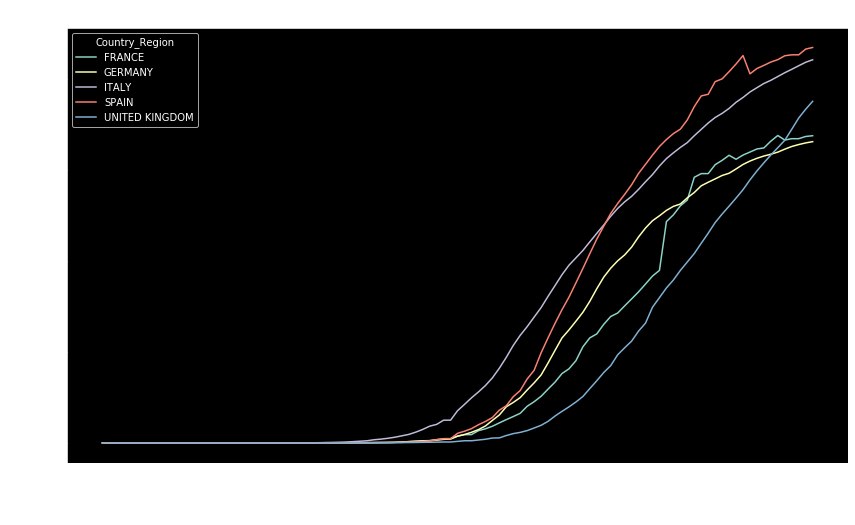

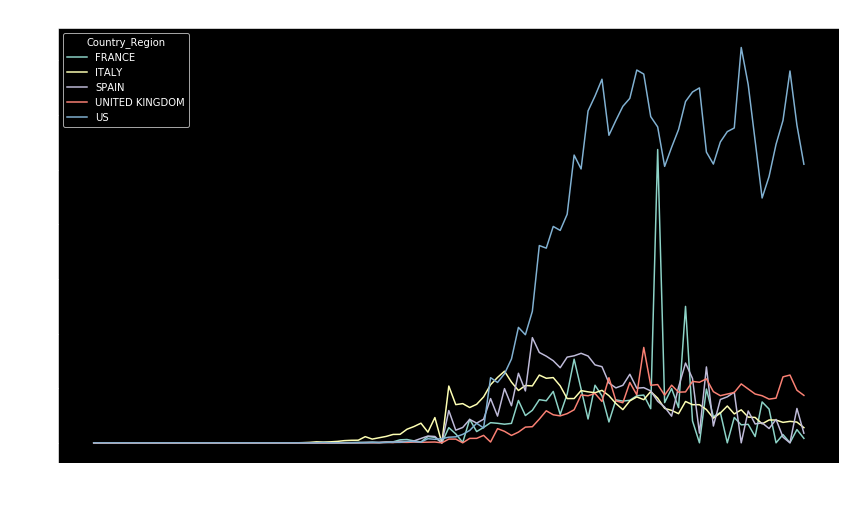

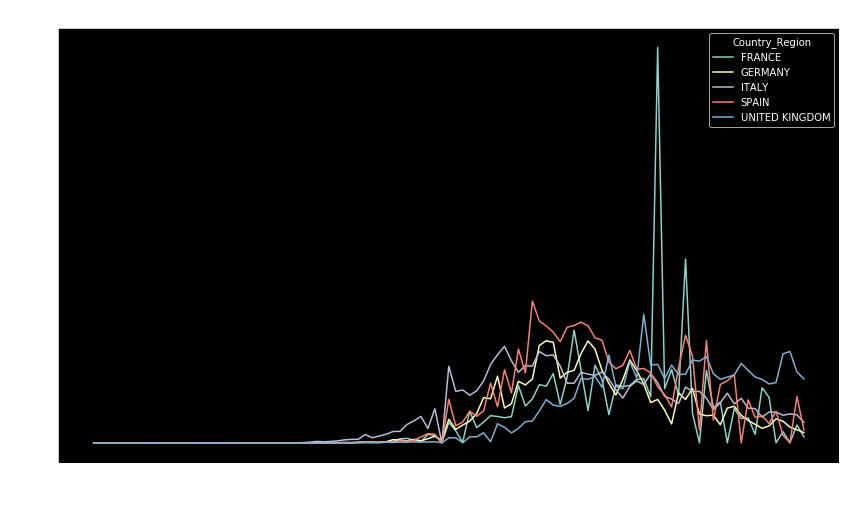

In [44]:
#plot cumulative trends
getCovidTrend(metric_cum, top_ius)
getCovidTrend(metric_cum, top_xus)
#plot daily trends
getCovidTrend(metric_new, top_ius)
getCovidTrend(metric_new, top_xus)

<font color='tan'>trend daily new cases

In [48]:
def addTrendLine(sel):
    """
    returns a seaborn lmplot of daily metric for each country
    specified in the selected list
    """
    #iterate over each country in list
    for item in sel:
        p_df = country_df.loc[country_df['Country_Region'] == item]\
        .sort_values(by=['Date'],ascending=True)
        p_df['days_since_jan22'] = (p_df['Date'] - p_df['Date'].min()).dt.days
        #plot
        sb.lmplot(x='days_since_jan22', y=metric_new, data=p_df, lowess=True, aspect=20/9, line_kws={'color': 'red'})
        plt.title(' Daily Covid-19 cases: '+item+' : '+metric_new, size=20)
        plt.xlabel('Days since Jan-22', size=14)
        plt.xticks(size=14, color='white')
        plt.yticks(size=14, color='white')
        plt.show()

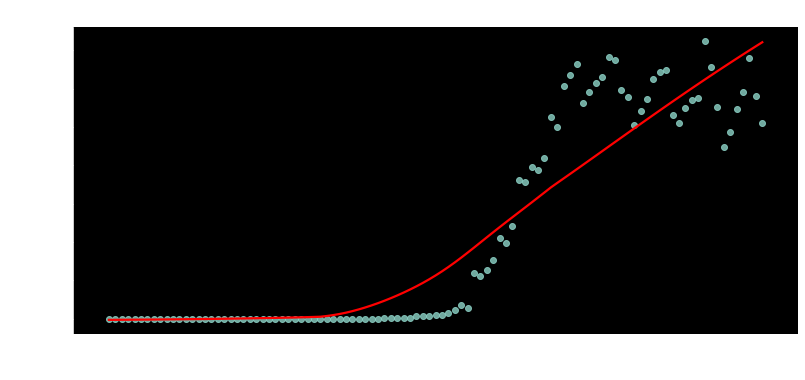

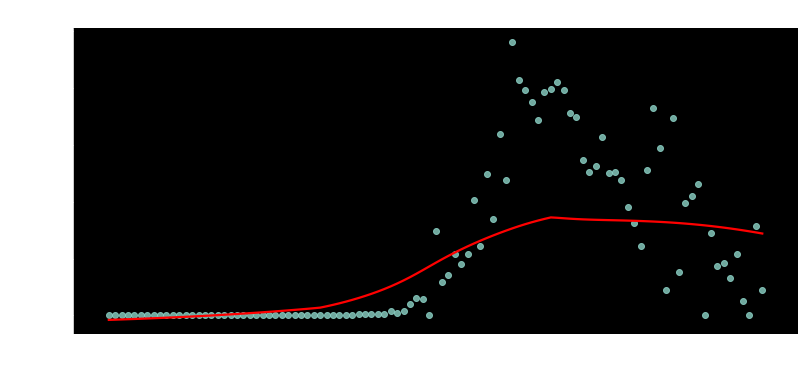

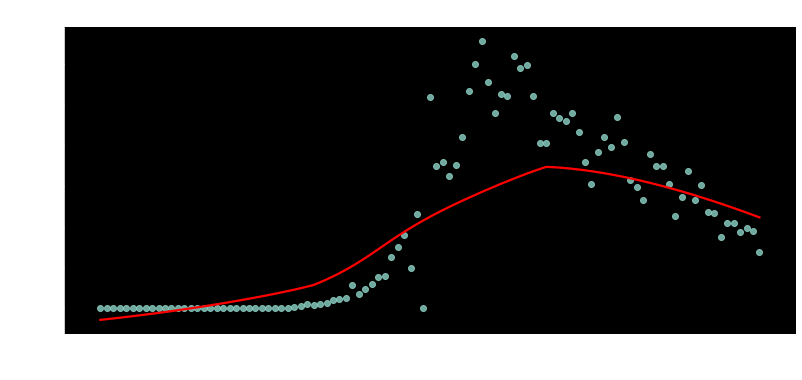

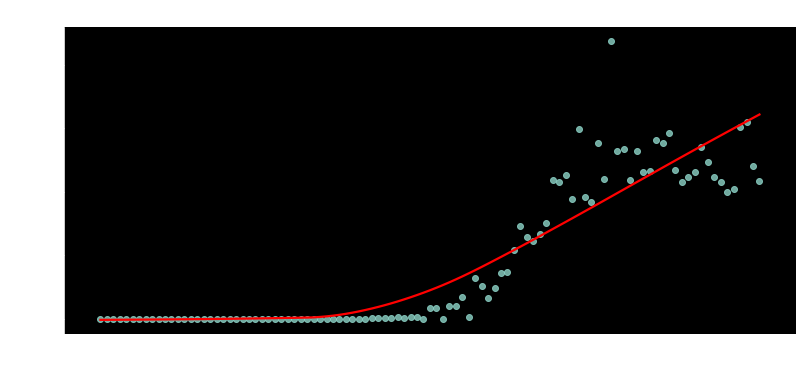

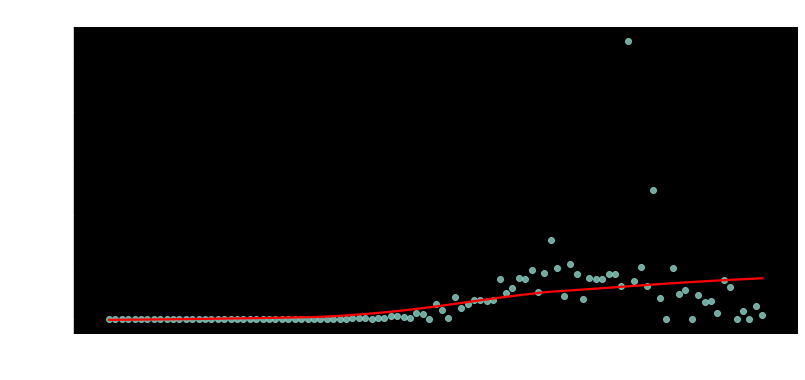

In [49]:
#plot trendline
addTrendLine(top_ius)

<font color='tan'> compute Case Fatality Rate (CFR)

In [53]:
#aggregate daily counts of Confirmed and Deaths by country
cfr_df = country_df.groupby(['Country_Region'])\
.agg({'Confirmed_New':'sum','Deaths_New':'sum'})\
.reset_index()
#rename columns and compute CFR
cfr_df.rename(columns={'Confirmed_New':'Cum_confirmed','Deaths_New':'Cum_deaths'}, inplace=True)
cfr_df['CFR'] = cfr_df['Cum_deaths'] / cfr_df['Cum_confirmed']

In [54]:
#filter for countries with at least 1000 infections
cfr_df = cfr_df.loc[cfr_df['Cum_confirmed'] >= 1000]\
.sort_values(by=['CFR'], ascending=False).reset_index()
cfr_df['CFR_rank'] = cfr_df.index.values + 1
#display top 25 countries by CFR
print('\nTop 25 countries with higest Case Fatality Rates: \n')
cfr_df.head(25)


Top 25 countries with higest Case Fatality Rates: 



,index,Country_Region,Cum_confirmed,Cum_deaths,CFR,CFR_rank
0,16,BELGIUM,49906.0,7844.0,0.157175,1
1,176,UNITED KINGDOM,187842.0,28520.0,0.151830,2
2,62,FRANCE,173623.0,24900.0,0.143414,3
3,85,ITALY,210717.0,28884.0,0.137075,4
4,121,NETHERLANDS,40769.0,5072.0,0.124408,5
5,161,SWEDEN,22317.0,2679.0,0.120043,6
6,77,HUNGARY,2998.0,340.0,0.113409,7
7,157,SPAIN,227500.0,25264.0,0.111051,8
8,2,ALGERIA,4474.0,463.0,0.103487,9
9,111,MEXICO,23471.0,2154.0,0.091773,10


In [55]:
#spot check rank of desired country
print('\nTotal number of countries: ', cfr_df['CFR_rank'].max())
country = 'SINGAPORE' #select country of choice
cfr_df.loc[cfr_df['Country_Region'] == country][['Country_Region','CFR','CFR_rank']]


Total number of countries:  89


,Country_Region,CFR,CFR_rank
87,SINGAPORE,0.000989,88


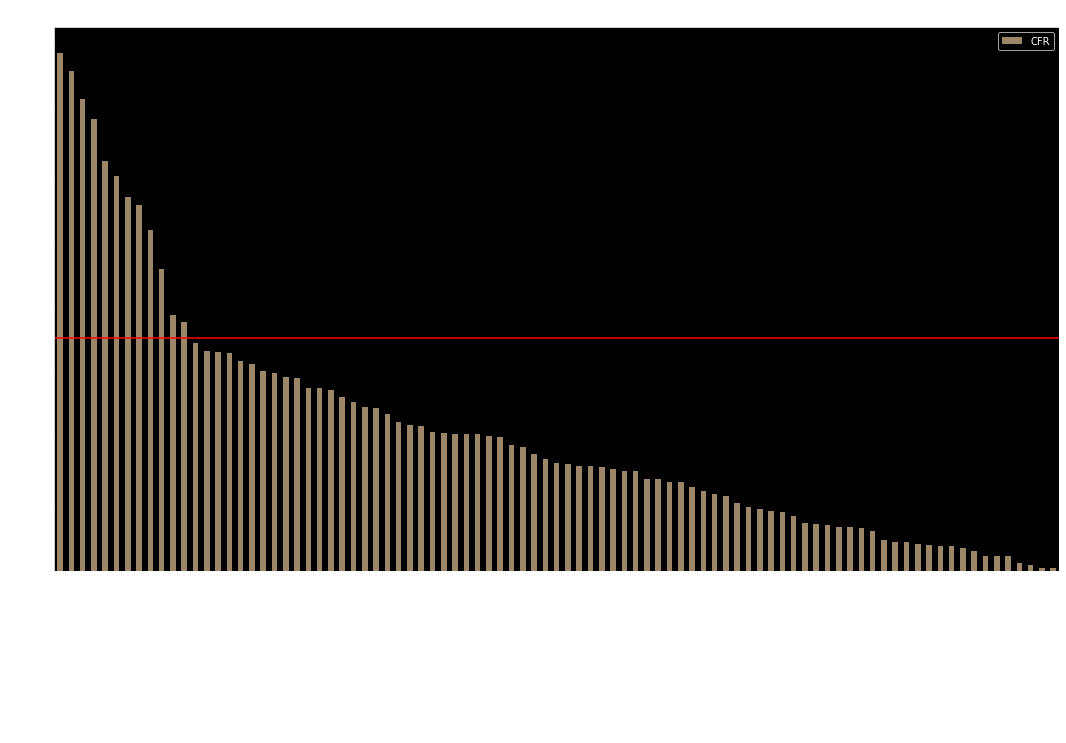

In [56]:
#plot Case Fatality Rates
cfr_df.sort_values(by=['CFR'], ascending=False)\
.plot.bar(x='Country_Region', y='CFR', figsize=(18,10), color='tan',alpha=0.75)
plt.axhline(y=cfr_df.Cum_deaths.sum()/cfr_df.Cum_confirmed.sum(), color = 'r')
plt.title('Case Fatality Rates by Country vs. Global Avg.', size=20)
plt.xlabel('Country', size=14)
plt.ylabel('CFR (%)',size=14)
plt.show()

<font color='tan'> end